<img src='http://www-scf.usc.edu/~ghasemig/images/sharif.png' alt="SUT logo" width=200 height=200 align=left class="saturate" >

<br>
<font face="Times New Roman">
<div dir=ltr align=center>
<font color=0F5298 size=7>
    Introduction to Machine Learning <br>
<font color=2565AE size=5>
    Computer Engineering Department <br>
    Fall 2022<br>
<font color=3C99D size=5>
    Homework 4: Practical - Convolutional Neural Networks <br>
<font color=696880 size=4>
    Arian Amani
    
    
____


### Full Name : Zahra Soukhtedel
### Student Number : 98105138
___

# Problem
This assignment uses PyTorch to build and implement a residual CNN for solving a classification problem. Our goal is to classify handwritten digits from 0 to 9 on the MNIST dataset. You can try larger and more fun datasets if you have access to Google Colab. (for example: [facial emotion detection](https://www.kaggle.com/datasets/msambare/fer2013))

* It is highly recommended to run this notebook on Google Colab so that you can utilize its GPU.
* If you need to change the inputs of functions you are implementing, or want to add new cells or functions, feel free to do so.

# Setup

In [91]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, datasets

from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('ggplot')
###########################################################
##  If you need any other packages, import them below    ##
###########################################################


In [92]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

# Prepare The Data (10 Points)

Write a composed transformation to transform our dataset's PIL images to tensors and normalize them with ```mean: 0.1307``` and ```std: 0.3081```: 

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html">torchvision.transforms.Compose</a>
</details>

In [93]:
from torchvision.transforms.transforms import ToTensor

transformation = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize((0.1307,), (0.3081,))])

Split the downloaded MNIST dataset into two dataloaders ```train``` & ```val```

In [94]:
# Download the MNIST dataset
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

# Number of images in the dataset: 60,000
print(len(mnist_data))

# Split the dataset into training and validation sets
train_data, valid_data = random_split(mnist_data, [50000, 10000]) 

60000


Create dataloaders for your train and validation data with ```batch size 16``` and ```shuffle = True``` for train loader.

<details>
<summary>Hint</summary>
<br>
<a href="https://pytorch.org/tutorials/beginner/basics/data_tutorial.html">DATASETS & DATALOADERS</a>
</details>

In [95]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(valid_data, batch_size=16, shuffle=False)

# Define Model (40 Points)

### You need to implement a model with the architecture below:
[Input: (BS, 1, 28, 28)] -- > [Conv2D (BS, 16, 28, 28)] --> ReLU --> [MaxPool2D (BS, 16, 14, 14): Residual1]

--> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Conv2D (BS, 16, 14, 14)] --> ReLU --> [Addition with Residual1]

--> [MaxPool2D (BS, 16, 7, 7)] --> [Conv2D (BS, 64, 7, 7)] --> [ReLU: Residual2]

--> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Conv2D (BS, 64, 7, 7)] --> ReLU --> [Addition with Residual2]

--> [GlobalAveragePooling (BS, 64, 1, 1)] --> [Flatten (BS, 64)] --> [Linear (BS, 10)] --> ReLU --> OUT

Here you can see the drawn schematic of the architecture, too: [Link](https://drive.google.com/file/d/1gQzafyxTkuvQr8T-xUncLmedX94LnY_l/view?usp=share_link)

<details>
<summary>Hint</summary>
<br>
These might be helpful:
<br>
<a href="https://pytorch.org/docs/stable/generated/torch.clone.html">TORCH.CLONE</a>
<br><br>
<a href="https://pytorch.org/docs/master/generated/torch.nn.AdaptiveAvgPool2d.html#torch.nn.AdaptiveAvgPool2d">AdaptiveAvgPool2d</a> with output size (1, 1) for global average pooling
<br><br>
<a href="https://arxiv.org/pdf/1512.03385.pdf">Deep Residual Learning for Image Recognition</a>
</details>

In [96]:
#####################################
##        Define your model        ##
##            Your Code            ##
#####################################
class ResidualClassifier(nn.Module):
    def __init__(self):
        super(ResidualClassifier, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, 1, 1),                          
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2, stride=2),    
        )
        self.layer2 = nn.Sequential(         
            nn.Conv2d(16, 16, 3, 1, 1),     
            nn.ReLU(),                 
            nn.Conv2d(16, 16, 3, 1, 1),     
            nn.ReLU()              
        )
        self.layer3 = nn.Sequential(        
            nn.MaxPool2d(kernel_size=2, stride=2),     
            nn.Conv2d(16, 64, 3, 1, 1),     
            nn.ReLU()
        )
        self.layer4 = nn.Sequential(         
            nn.Conv2d(64, 64, 3, 1, 1),     
            nn.ReLU(),                 
            nn.Conv2d(64, 64, 3, 1, 1),     
            nn.ReLU()              
        )
        self.out_layer = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(), 
            nn.Linear(64, 10)
        )
    def forward(self, x):
        output_layer1 = self.layer1(x)
        output_layer2 = self.layer2(output_layer1) + output_layer1
        output_layer3 = self.layer3(output_layer2)
        output_layer4 = self.layer4(output_layer3) + output_layer3
        out = self.out_layer(output_layer4)
        return out

# Train Model (30 Points)

In [98]:
from torch.optim import SGD as SGD

model = ResidualClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=0.0005, momentum = 0.95)  


In [99]:
total_step = len(train_loader)
num_epochs = 20
valid_loss = []
valid_accuracies = []

for epoch in range(num_epochs):
    running_loss = 0
    model.train()
    for images, labels in train_loader:  
        optimizer.zero_grad()
        loss = criterion(model.forward(images.to(device)), labels.to(device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    valid_loss.append(running_loss / total_step)
  
    print ('Epoch [{}], training loss: {:.4f}'.format(epoch+1, loss.item()))
      
    loss, accuracy = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            out = model.forward(images)
            
            loss += criterion(out, labels).item()
            eq = (labels == (torch.exp(out)).max(dim=1)[1])
            
            accuracy += eq.type(torch.FloatTensor).mean()
            
            del images, labels, out

        print('Validation accuracy : {:.4f}%, validation loss : {:.4f} %'.format(100*accuracy/len(val_loader), 100*loss/len(val_loader))) 
        valid_loss.append(loss)
        valid_accuracies.append(accuracy)    

Epoch [1], training loss: 0.3891
Validation accuracy : 89.6200%, validation loss : 33.7715 %
Epoch [2], training loss: 0.3741
Validation accuracy : 94.1400%, validation loss : 18.4739 %
Epoch [3], training loss: 0.0449
Validation accuracy : 96.4100%, validation loss : 12.3963 %
Epoch [4], training loss: 0.1020
Validation accuracy : 96.4000%, validation loss : 11.6481 %
Epoch [5], training loss: 0.0072
Validation accuracy : 96.9300%, validation loss : 9.5750 %
Epoch [6], training loss: 0.0448
Validation accuracy : 97.3000%, validation loss : 8.4425 %
Epoch [7], training loss: 0.0193
Validation accuracy : 97.7600%, validation loss : 7.2688 %
Epoch [8], training loss: 0.3879
Validation accuracy : 97.4300%, validation loss : 8.1693 %
Epoch [9], training loss: 0.0145
Validation accuracy : 97.6500%, validation loss : 7.8536 %
Epoch [10], training loss: 0.0845
Validation accuracy : 97.9400%, validation loss : 6.5108 %
Epoch [11], training loss: 0.0040
Validation accuracy : 98.3800%, validatio

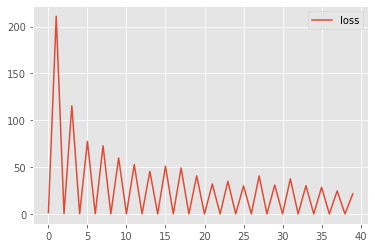

In [100]:
import matplotlib.pyplot as plt

plt.plot(valid_loss, label='loss')
plt.legend()
plt.show()

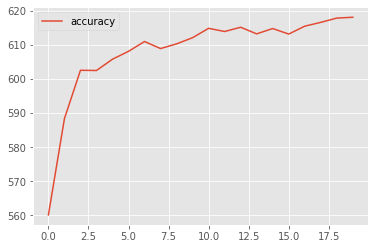

In [101]:
plt.plot(valid_accuracies, label='accuracy')
plt.legend()
plt.show()

# Test Model (20 Points)

In [102]:
##################################################
##          Test your model on test-set         ##
##          and plot confusion matrix           ##
##################################################

test_data = datasets.MNIST(root='data/', download=True, transform=transformation, train=False)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)
print(len(test_data))


real = []
pred = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images,labels = images.to(device), labels.to(device)

        outputs = model(images)
        predicted = (torch.max(outputs.data, 1)[1]).cpu().numpy()

        correct += sum(predicted == labels.cpu().numpy()).item()
        total += labels.size(0)
        real.extend(labels.cpu().numpy())
        pred.extend(predicted)

        del images, labels, outputs

10000


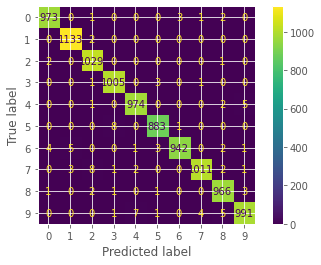

In [103]:
#confusion matrix 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
ConfusionMatrixDisplay(confusion_matrix(real, pred)).plot()